Dieses Notebook enthält den Code, mit dem die Simulationen für die Operatorausbreitung im Ising Modell mit transversalem und longitudinalem Feld durchgeführt wurden. Der Code wurde auf dem PGI8Cluster laufen gelassen um die Operatordichten $\rho_{L}(x,t)$ und $\rho_{L}(x,t)$ zu bestimmen unter der Dynamik des Ising Modells. Alle generierten Daten sind in einem sepraten Notebook **Ising_Modell_Auswertung_final.ipynb** ausgewertet worden.

In [2]:
using ITensors
using LinearAlgebra
using Random
using DelimitedFiles
using Printf

Um die Zeitentwicklung eines Operators zu bestimmen wird der TEBD Algorithmus verwendet, welcher in Abschnitt 2.3 der Bachelorarbeit beschrieben wird. Zunächst wird eine Funktion **U_layer** geschrieben, welche für den Ising Hamiltonian die Lagen $\mathrm{e}^{-i\delta H_{\text{gerade}}}$ und  $\mathrm{e}^{-i\frac{\delta}{2}H_{\text{ungerade}}}$ berechnet bzw. die Tensoren von Rang 4 aus denen die Lagen bestehen, vergleiche mit Bachlorarbeit. Die Randtensoren sind in der Implementierung enthalten.

Leicht anders als in der Bachelorarbeit beschrieben, wurde für die Implementierung der Hamiltonain als $H = H_{\text{ungerade}} + H_{\text{gerade}}$ zerlegt mit:
$H_{\text{ungerade}} = \sum_{\text{$i$ ungerade}}JS_{i}^{x}S_{i+1}^{x} + \frac{h_{x}}{2}(S_{i}^{x} + S_{i+1}^{x})+\frac{h_{z}}{2}(S_{i}^{z}+S_{i+1}^{z}) + \frac{h_{x}}{2}S_{1}^{x}+\frac{h_{z}}{2}S_{1}^{z}$

$H_{\text{gerade}} = \sum_{\text{$i$ gerade}}JS_{i}^{x}S_{i+1}^{x} + \frac{h_{x}}{2}(S_{i}^{x} + S_{i+1}^{x})+\frac{h_{z}}{2}(S_{i}^{z}+S_{i+1}^{z}) + \frac{h_{x}}{2}S_{L}^{x}+\frac{h_{z}}{2}S_{L}^{z}$

also wurden die Randtensoren in $H_{\text{ungerade}}$ bzw. $H_{\text{gerade}}$ eingebaut.

In [4]:
#=
Die Funktion bekommt ein Vektor sites bestehend aus ITensor Indizes,
delta entspricht dem lokalen Zeitschritt des TEBD Algorithmus, 
odd ist ein Boolean welcher bestimmt ob die Lage generiert durch H_ungerade oder die Lage aus H_gerade erzeugt werden soll,
L ist die Systemgröße welche o.B.d.A. gerade ist, 
(J,hx,hz) sind die Parameter im Ising Modell
=#
function U_layers(sites, delta, odd, L, J, hx, hz)
    
    #Array U_alpha initialisieren in dem sich die Tensoren von Rang 4 befinden aus dem unser Schaltkreis aufgebaut ist:
    U_alpha = ITensor[]

    
    
    #Summe über ungerade Indizes (H_ungerade):
    if odd == true
        
        #Über alle Gitterpunkte iterieren
        for j in 1:2:(L - 1)
            s1 = sites[j]
            s2 = sites[j + 1]
            #Auftretende Operatoren an den richtigen Stellen im Gitter Definieren
            Sx1 = op("Sx", s1)
            Sx2 = op("Sx", s2)
            Sz1 = op("Sz", s1)
            Sz2 = op("Sz", s2)
            Id1 = op("Id", s1)
            Id2 = op("Id", s2)
            
            #Trotter-Suzuki-Zerlegung:
            
            #Randterm addieren (für j=1 werden die Randterme berücksichtigt vergleiche mit H_ungerade oben):
            if j == 1
                hj =
                J * Sx1 * Sx2 +
                hx / 2 * (Sx1 * Id2 + Id1 * Sx2) +
                hz / 2 *(Sz1 * Id2 + Id1 * Sz2) +
                hx/2 * Sx1 * Id2 + hz/2 * Sz1 * Id2 #hier wird Randterm addiert
                
                #Gj sind die Tensoren aus denen unser Schaltkreis besteht
                Gj = exp(-im * delta * hj)
                push!(U_alpha,Gj)
                continue
            end
            
            #die kummutierenden Summanden h_{i,i+1} initialisieren
            hj =
                J * Sx1 * Sx2 +
                hx / 2 * (Sx1 * Id2 + Id1 * Sx2) +
                hz / 2 *(Sz1 * Id2 + Id1 * Sz2)
            
            #Gj sind die Tensoren aus denen unser Schaltkreis besteht
            Gj = exp(-im * delta * hj)
            push!(U_alpha,Gj)
        end
        
    #Summe über gerade Indices (H_gerade):
    else
        for j in 2:2:(L - 2)
            s1 = sites[j]
            s2 = sites[j + 1]
            #Auftretende Operatoren an den richtigen Stellen im Gitter Definieren
            Sx1 = op("Sx", s1)
            Sx2 = op("Sx", s2)
            Sz1 = op("Sz", s1)
            Sz2 = op("Sz", s2)
            Id1 = op("Id", s1)
            Id2 = op("Id", s2)
            
            #die kummutierenden Summanden h_{i,i+1} initialisieren
            hj =
                J * Sx1 * Sx2 +
                hx / 2 * (Sx1 * Id2 + Id1 * Sx2) +
                hz / 2 *( Sz1 * Id2 + Id1 * Sz2)
            
            #Gj sind die Tensoren aus denen unser Schaltkreis besteht
            Gj = exp(-im * delta * hj)
            push!(U_alpha,Gj)
        end
        
        #Randterm hinzufügen (an der Stelle L werden die Randterme berücksichtigt vergleiche mit H_gerade oben):
        Gj = exp(-im * delta * (hx/2 * op("Sx", sites[L]) + hz/2 * op("Sz", sites[L])))
        push!(U_alpha,Gj)
    end

    
    return U_alpha
end

U_layers (generic function with 1 method)

Mit der Funktion **U_layers**, die uns die Lagen im TEBD Algorithmus berechnet, kann jetzt die Zeitentwicklung nach einem lokalen Zeitschritt $\delta$ berechnet werden. Dafür müssen die Lagen wie in Abb.(2.4) der Bachelorarbeit auf den MPO $S_{0}$ angewendet werden. Um einen Zeitschritt $t=1$ zu erhalten müssen iterativ $t/\delta$ lokale Zeitschritte $\delta$ gemacht werden, wie es in der Bachelorarbeit beschrieben ist. 

In [6]:
#=
S0 ist ein MPO der um einen Zeitschritt entwickelt werten soll
W_odd bzw. W_even sind die Lagen die in Sandwitch-Form auf den MPO wirken, vergleiche Abb. 2.4 der Bachelorarbeit 
delta ist der lokale Zeitschritt im TEBD Algorithmus
L ist die Systemgröße
(J,hx,hz) sind die Parameter des Ising Hamiltonians
bond_dim ist die maiximal erlaubte Bond Dimension
=#
function TEBD_single_timestep(S0, W_odd, W_even, delta, L, J, hx, hz, bond_dim)
    
    #Nur ein Zeitschritt:
    t=1 
    sites = siteinds(S0, plev = 0)
    #gesamt Anzahl an lokalen Zeitschritten die iterativ durchgeführt werden müssen
    tsteps = ceil(t/delta) 
    S = copy(S0)
    L = length(S)
   
    
    #TEBD2 Algorithmus anwenden mit den Trotter-Gatter die mit U_layers erstellt werden: 
    for n in 1:tsteps
        
    
        #Zuerst wird die Lage odd, danach die Lage even und dann wieder odd angewendet (vergleiche Abb. 2.4), dabei führt
        #die Funktion apply eine Kompression der Bond Dimension durch, um den neuen Operator wieder als MPO darstellen zu können
        S = apply(W_odd, S; maxdim = bond_dim, apply_dag=true)
        S = apply(W_even, S; maxdim = bond_dim, apply_dag=true) 
        S = apply(W_odd, S; maxdim = bond_dim, apply_dag=true) 
        
        
    end
    
    #Normalisiert den MPO S auf 1
    normalize!(S)
    
    return S
end

TEBD_single_timestep (generic function with 1 method)

Mit den oben beschriebenen Funktionen kann die Zeitentwicklung eines Operator $S_{0}$, unter der Dynamik generiert durch den Ising Hamiltonian, berechnet werden. Die folgenden Funktionen zur Bestimmung der Operatordichten $\rho_{R}(x,t)$ bzw. $\rho_{L}(x,t)$ entsprechen genau den Funktionen, die auch für das zufällige Quantenschaltkreis verwendet wurden.

In [10]:
#Funktion berechnet das totale Gewicht aller Paulistrings mit rechten Endpunkt x_r in der Basisentwicklung von S(t):

function rho_R(S,x_r)
    
    sites = siteinds(S, plev = 0)
    Sc = copy(S)
    
    #Bringe den MPO Sc in gemischt-kanonische Form mit Orthogonalisierungszentrum bei x_r, damit die Kontraktion der Tensoren 
    #links von x_r trivial wird, vergleiche Bachelorarbeit:
    orthogonalize!(Sc, x_r)
    L = length(S)
    
    # 1. Berechne den in der Bachelorarbeit genannte Tensor T, indem alle Tensoren rechts von x_r auf die Identität projiziert
    #werden und kontrahiere über alle Bond Indizes in T:
    
    T = ITensor(1)
    for i in L:-1:x_r+1
        #Die i-te Stelle des MPOs Sc wird auf die Identität projiziert
        R = Sc[i]
        #Definiere den Identitäts Tensor an der Stelle i
        id = op("Id", sites[i])
        #projiziere auf die Identität und kontrahiere die Bond Indizes (teile durch sqrt(2) zur Normierung)
        T *= (R * id) * 1/sqrt(2)
    end
    
    # 2. Projiziere Gitterpunkt x_r auf die Pauli Matrizen X, Y und Z:
    
    #Multipliziere die Stelle x_r im MPO Sc mit T
    O = Sc[x_r]
    R = O*T
    
    #Wir projizieren auf die drei Pauli-Matrizen
    projection = ["X", "Y", "Z"]
    #RHO_R ist die Variable in der unser Ergebnis für die Operatordichte rho_R(x,t) abgespeichert wird
    RHO_R = 0
    for m in projection
       
        #Pauli-Matrizen als Tensor an der Stelle x_r
        proj_op = op(m, sites[x_r])
        #Berechne die Projektion auf einen der drei Pauli-Matrizen (teile durch sqrt(2) zur Normierung)
        rho_xyz = R * proj_op * 1/sqrt(2) 
        #addiere die Projektionen auf die drei Pauli-Matrizen zusammen
        RHO_R += scalar(rho_xyz * dag(rho_xyz))
        
    end

    
    return abs(RHO_R) 
    
end

#Funktion berechnet das totale Gewicht aller Paulistrings mit linken Endpunkt x_l in der Basisentwicklung von S(t):
function rho_L(S,x_l)
    
    sites = siteinds(S, plev = 0)
    Sc = copy(S)
    
    #Bringe den MPO Sc in gemischt-kanonische Form mit Orthogonalisierungszentrum bei x_l, damit die Kontraktion der Tensoren 
    #rechts von x_l trivial wird:
    orthogonalize!(Sc, x_l)
    L = length(S)
    
    # 1. Berechne den Tensor T indem wir die sites 1:x_l-1 auf die Identität projizierne und
    # kontrahiere über alle Bond Indices in T:
    
    T = ITensor(1)
    for i in 1:x_l-1
        #Die i-te Stelle des MPOs Sc wird auf die Identität projiziert
        R = Sc[i]
        #Definiere den Identitäts Tensor an der Stelle i
        id = op("Id", sites[i])
        #projiziere auf die Identität und kontrahiere die Bond Indizes (teile durch sqrt(2) zur Normierung)
        T *= (R * id) * 1/sqrt(2)
    end
    
    # 2. Projiziere site x_l auf die Pauli-Matrizen X, Y und Z
    
    #Multipliziere die Stelle x_l im MPO Sc mit T
    O = Sc[x_l]
    R = O*T
    
    #Wir projizieren auf die drei Pauli-Matrizen
    projection = ["X", "Y", "Z"]
    #RHO_L ist die Variable in der unser Ergebnis für die Operatordichte rho_L(s,t) abgespeichert wird
    RHO_L = 0
    for m in projection
       
        #Pauli Matrizen als Tensor an der Stelle x_l
        proj_op = op(m, sites[x_l])
        #Berechne die Projektion auf einen der drei Pauli-Matrizen (teile durch sqrt(2) zur Normierung)
        rho_xyz = R * proj_op * 1/sqrt(2)
        #addiere die Projektionen auf die drei Pauli-Matrizen zusammen
        RHO_L += scalar(rho_xyz * dag(rho_xyz))
        
    end

    
    return abs(RHO_L) 
    
end

rho_L (generic function with 1 method)

In der Funktion **generate_data** werden alle vorher geschriebenen Funktionen zusammengefasst. Es wird mit **TEBD_single_timestep** für fest bestimmte Parameter $(J,h_{x},h_{z})$ des Ising-Modells iterativ die Zeitentwicklung eines Operators $S_{0}$ simuliert und nach jedem Zeitschritt die Operatordichten $\rho_{L}(x,t)$ und $\rho_{R}(x,t)$ $\forall x$ mit den Funktionen **rho_L** bzw. **rho_R** berechnet. Die beiden Operatordichten werden jeweils als Array der Dimension $(t+1\times L)$ zurückgegeben, wobei die Operatordichten bei $t=0$ auch abgespeichert werden.

In [13]:
#Erzeuge die Zeitentwicklung unter des Ising Hamiltonians und berechnet die beiden Operatordichten

#=
S0 ist ein MPO der um eine Zeit t entwickelt werden soll
delta ist der lokale Zeitschritt im TEBD Algorithmus
t ist die gesamte Simulationszeit
(J,hx,hz) sind die Parameter des Ising Hamiltonians
bond_dim ist die maiximal erlaubte Bond Dimension
=#

function generate_data(S_0, delta, t, J, hx, hz, bond_dim)
    
    sites = siteinds(S_0, plev = 0)
    L = length(S_0)
    
    #Berechne die Lagen im TEBD Algorithmus mit der Funktion U_layers
    W_odd = U_layers(sites, delta/2, true, L, J, hx, hz) #bei ungerader Lage ist der Zeitschritt \delta/2 
    W_even = U_layers(sites, delta, false, L, J, hx, hz) #bei gerader Lage ist der Zeitschritt \delta vgl. Abb.2.4
    
    #Anfangsstring normieren
    S_prev = copy(S_0) 
    S_prev ./= sqrt(2)

    #Arrays initialisiern um die Operatordichten zu speichern
    RHO_R = zeros(t+1,L)
    RHO_L = zeros(t+1,L)

    #Operatordichten des Produktzustands S_prev (bei t=0) speichern:
    for s in 1:L
        RHO_R[t+1,s] = rho_R(S_prev,s)
        RHO_L[t+1,s] = rho_L(S_prev,s)
    end
    
    #Iteriere über alle Zeiten
    for n in 1:t
        
        #Der Anfangsstring wird durch die Funktion TEBD_single_timestep um einen Zeitschritt entwickelt und bekommt den MPO vom 
        #vorherigen Zeitschritt wieder übergeben
        S_new = TEBD_single_timestep(S_prev, W_odd, W_even, delta, L, J, hx, hz, bond_dim)
        
        #Berechne für den Zeitpunkt t die Operatordichten rho_L(x,t) und rho_R(x,t) an allen Gitterpunkten
        for s in 1:L

            RHO_R[t+1-n,s] = rho_R(S_new,s)
            RHO_L[t+1-n,s] = rho_L(S_new,s) 
            
        end
        
        #Setze S_prev auf den neuen Zeitentwickelten MPO S_new um in der nächsten Iteration den nächsten Zeitschritt zu erhalten
        S_prev = S_new
        
    end
    
    
    return RHO_L, RHO_R 
end

generate_data (generic function with 1 method)

Mit dem Code kann jetzt die Simulation durchgeführt werden:

In [36]:
#Parameter festlegen:
delta= 0.2 #lokaler Zeitschritt des TEBD-Algorithmus
t = 10 #Gesamtzeit um die der Anfangsstring S_0 entwickelt werden soll
L = 20 #Länge der Kette
pos0 = L÷2 #Position auf die der Anfangsstring S_0 lokalisiert ist
bond_dim = 30 #maximale Bond Dimension

#Parameter des Ising Modells
J=1 
# hx=[0.0] 
hz=0.8
hx = [s for s in  0.5:0.1:0.5]
 
#Hilbertraum des gesamten Systems definieren
sites = siteinds("S=1/2",L)
#Anfangs Paulistring definieren
Config = repeat(["Id"],L)
Config[pos0] = "Z" #lokalisiert auf pos0 mit Operator Z
Sz = MPO(sites, Config)
S0 = copy(Sz) 
    
#Name des Ordners wo die Daten abgespeichert werden
output_folder = "Ising_test"
#erzeugt Ordner mit dem Namen "output_folder"
mkpath(output_folder)

#Führe für jeden longitudinale Komponente hx eine Simulation durch
for j in hx
    t1 = time() #zur Zeitmessung
    #die Operatordichten für alle Zeiten und Positionen erzeugen
    RHO_L, RHO_R = generate_data(S0, delta, t, J, j, hz, bond_dim)

    #Zur besseren Handhabung der Daten
    RHO_L[abs.(RHO_L) .< 1E-16] .= 0
    RHO_R[abs.(RHO_R) .< 1E-16] .= 0

    #Um die Daten den gewählten Parametern zuordnen zu können
    filename = "J_"  * string(J) * "_hx_" * string(j) * "_hz_" * string(hz) * "_result.txt"
    output_file = joinpath(output_folder, filename) 
    t2 = time()
    @printf("Needed time[s]: %0.3f\n", t2 - t1)

    #Fülle die .txt Datei "filename" mit den Operatordichten und speicher sie in "output_folder"
    open(output_file, "w") do io
            writedlm(io, [RHO_L RHO_R])
    end
end

Needed time[s]: 16.737


Zum testen des Codes, kann auf einem lokalen Rechner eine Simulation mit der vorigen Zelle durchgeführt werden. Die Daten können mit der folgenden Zelle geladen und geplottet werden. Wobei die Daten, welche auf dem PGI8Cluster erzeugt wurden, wie oben erwähnt, in einem seperaten Notebook **Ising_Modell_Auswertung_final.ipynb** ausgewertet werden.

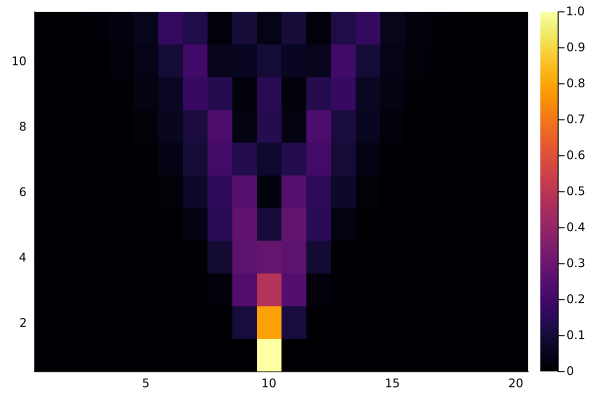

In [42]:
#Test der generierten Daten Simulation
using Plots


#Ordner mit den Daten:
output_folder = "Ising_test"

#Zum laden der Daten:
files = joinpath.(output_folder, readdir(output_folder))

L_f = length(files)

#Arrays definieren in die unsere Daten geladenen werden:
res_r = Vector{Matrix{Float64}}(undef, L_f) #Hier wird rho_l für jeden Seed abgespeichert
res_l = similar(res_r) #Hier wird rho_r für jeden Seed abgespeichert

#Alle Daten im Ordner durchgehen und in res_l und res_r speichern
for (j,f) in enumerate(files[1:L_f])
    res = readdlm(f)
    L2 = size(res,2)
    @assert iseven(L2)
    L = div(L2,2)
    #Die ersten L Werte enstprechen der Operatordichte rho_L
    res_l[j] = reverse(res[:, 1:L],dims=1)
    #Die letzten L Werte enstprechen der Operatordichte rho_R
    res_r[j] = reverse(res[:, L+1:end], dims = 1)
end

heatmap((res_l[1]+res_r[1])/2)